In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from numpy import pi, e
from numpy.linalg import inv, det
from numpy.linalg import norm as LA_norm
from numpy.random import random
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
from termcolor import colored
import itertools
from itertools import combinations, product

In [2]:
def create_matrix(m, n):
    return np.random.rand(m, n)

def initial_inputs(flag):
    if flag == 0:
        # Create initial encoder inputs (B, Sigma_W)
        B = create_matrix(m, n)
        Sigma_W = make_spd_matrix(m)
        return np.concatenate(([flag], B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        # Create initial decoder inputs (A, Sigma_Z)
        A = create_matrix(n, m)
        Sigma_Z = np.diag(random(n))
        return np.concatenate(([flag], A.reshape((n*m)), Sigma_Z.reshape((n*n))))

def is_close_to_zero(arr, etol):
    return np.allclose(arr, 0, atol=etol)

def is_singular(matrix):
    is_singular = np.linalg.matrix_rank(matrix) < min(matrix.shape)
    if is_singular:
        print(colored('The matrix is singular.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not singular.', 'red', attrs=['bold']))

def is_positive_definite(matrix):
    if np.all(np.linalg.eigvals(matrix) > 0):
        print(colored('The matrix is positive definite.', 'red', attrs=['bold']))
    else:
        print(colored('The matrix is not positive definite.', 'red', attrs=['bold']))

def matrix_B(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    B = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A) @ A.T @ inv_Sigma_Z_hat
    return B

def covariance_matrix_W(A, Sigma_Z):
    inv_Sigma_Z_hat = gamma * inv(Sigma_Z) + 2 * lamda * np.identity(n)
    Sigma_W = inv(np.identity(m) + A.T @ inv_Sigma_Z_hat @ A)
    return Sigma_W

def matrix_A(B, Sigma_W):
    A = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B) @ B.T @ inv(Sigma_W)
    return A

def covariance_matrix_Z(B, Sigma_W):
    Sigma_Z = inv(inv(Sigma_Y) + B.T @ inv(Sigma_W) @ B)
    diagonalized_Sigma_Z = np.diag(Sigma_Z.diagonal())
    return diagonalized_Sigma_Z

def covariance_matrix_XV(B):
    cov_XV = np.block([[np.identity(m), B @ eigenvectors @ Sigma_V],
                       [(B @ eigenvectors @ Sigma_V).T, Sigma_V]])
    return cov_XV

def encoder_mi(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(Sigma_W))

def decoder_mi(A, Sigma_Z):
    return 0.5 * np.log(det(A @ A.T + Sigma_Z) / det(Sigma_Z))

def mi_VX(B, Sigma_W):
    return 0.5 * np.log(det(B @ Sigma_Y @ B.T + Sigma_W) / det(sigma_squared * B @ B.T + Sigma_W))

def reconstruction_error(recon, orig):
    norm_diff = LA_norm(orig - recon, 2)
    orig_norm = LA_norm(orig, 2)
    recon_err = norm_diff / orig_norm
    return recon_err

def objective_function(A, B, Sigma_Z, Sigma_W):
    Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
    
    regularizer = 0.5 * (np.trace(Sigma_X) - np.log(det(Sigma_W)) - m)
    reconstruction = 0.5 * (np.trace(Sigma_X) + \
                            np.trace(A.T @ inv(Sigma_Z) @ Sigma_Y @ B.T) + \
                            np.trace(inv(Sigma_Z) @ A @ B @ Sigma_Y) - \
                            np.trace(inv(Sigma_Z) @ Sigma_Y) - \
                            np.trace((np.identity(m) + A.T @ inv(Sigma_Z) @ A) @ Sigma_X) - \
                            n * np.log(2 * pi) - np.log(det(Sigma_Z)))
    lambda_term = lamda * np.trace((np.identity(n) - A @ B) @ Sigma_Y @ ((np.identity(n) - A @ B).T) + A @ Sigma_W @ A.T)
    
    return regularizer - gamma * reconstruction + lambda_term

In [3]:
def plot_cost_function(cf_arr):
    """
    Plot values of objective function against iterations t
    """
    plt.plot(range(1, len(cf_arr) + 1), cf_arr)
    plt.xlabel('t')
    plt.ylabel('Cost Function', fontsize=10)
    plt.show()

def plot_encoder_mi(en_mi_arr):
    """
    Plot mutual information of encoder against iterations t
    """
    plt.plot(range(1, len(en_mi_arr) + 1), en_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Encoder', fontsize=10)
    plt.show()

def plot_decoder_mi(de_mi_arr):
    """
    Plot mutual information of decoder against iterations t
    """
    plt.plot(range(1, len(de_mi_arr) + 1), de_mi_arr)
    plt.xlabel('t')
    plt.ylabel('Mutual Information of Decoder', fontsize=10)
    plt.show()

In [4]:
def print_optimal_solution(sol, m):
    A_arr = sol[:n*m] 
    B_arr = sol[n*m:2*n*m]
    Sigma_Z_arr = sol[2*n*m:2*n*m+n*n]
    Sigma_Z = Sigma_Z_arr.reshape((n, n))
    Sigma_W_arr = sol[2*n*m+n*n:2*n*m+n*n+m*m]
    Sigma_W = Sigma_W_arr.reshape((m, m))
    cost_function = sol[2*n*m+n*n+m*m:2*n*m+n*n+m*m+1][0]
    en_mi = sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0]
    de_mi = sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0]
    recon_err = sol[-1]
    len_cf_mi_arr = sol[2*n*m+n*n+m*m+3:2*n*m+n*n+m*m+6]
    Sigma_X = sol[2*n*m+n*n+m*m+6:2*n*m+n*n+2*m*m+6].reshape((m, m))
    Sigma_Y_hat = sol[2*n*m+n*n+2*m*m+6:2*n*m+2*n*n+2*m*m+6].reshape((n, n))
    
    print(colored('At optimal solution:', attrs=['bold']))
    
    if m > 1:
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))
        print('\nReconstruction error:\n{}'.format(round(recon_err, 8)))
    else:
        print('\nMutual information of the encoder:\n{}'.format(round(en_mi, 4)))     
        print('\nReconstruction error:\n{}'.format(round(recon_err, 8)))
        
    return len_cf_mi_arr

def print_comprehensive_results(gamma, lamda, flag, m, n, is_arr):
    if flag == 0:
        # Generate random initial encoder inputs (B, Sigma_W)
        B, Sigma_W = initial_inputs(flag)[1:1+m*n].reshape((m, n)), initial_inputs(flag)[1+m*n:1+m*n+m*m].reshape((m, m))
    else:
        # Generate random initial decoder inputs (A, Sigma_Z)
        A, Sigma_Z = initial_inputs(flag)[1:1+n*m].reshape((n, m)), initial_inputs(flag)[1+n*m:1+n*m+n*n].reshape((n, n))
    
    # Print given inputs
    if is_arr == 0:
        if m > 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial matrix B:')
            print(np.round(B.reshape((m, n)), 4))
            print('\nInitial covariance matrix of W:')
            print(np.round(Sigma_W, 4))
        elif m == 1 and flag == 0:
            print(colored('Given encoder X:', attrs=['bold']))
            print('Initial vector b:')
            print(np.round(B.reshape((m, n)), 4)[0])
            print('\nInitial variance of W:')
            print(np.round(Sigma_W, 4)[0][0])
        elif m > 1 and flag == 1:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial matrix A:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))
        else:
            print(colored('Given decoder Y_hat:', attrs=['bold']))
            print('Initial vector a:')
            print(np.round(A.reshape((n, m)), 4))
            print('\nInitial covariance matrix of Z:')
            print(np.round(Sigma_Z, 4))    
    
        # Print results
        if flag == 0:
            # Compute optimal solution given encoder inputs
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
    
            # Extract length of arrays for cost function and mutual information of encoder and decoder
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            # Plot values of cost function and mutual information against iterations
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)  
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
        
            len_all_arrs = print_optimal_solution(opt_sol, m).astype(int)
            len_cf_arr, len_en_mi_arr = len_all_arrs[:2]
            len_cf_en_mi_arr = len_cf_arr + len_en_mi_arr
        
            cf_arr = opt_sol[2*n*m+2*n*n+2*m*m+6 : 2*n*m+2*n*n+2*m*m+6+len_cf_arr]
            plot_cost_function(cf_arr)
    
            en_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_arr : 2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr]
            plot_encoder_mi(en_mi_arr)
    
            de_mi_arr = opt_sol[2*n*m+2*n*n+2*m*m+6+len_cf_en_mi_arr:]
            plot_decoder_mi(de_mi_arr)
    else:
        if flag == 0:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 8)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 8)
            recon_err = round(opt_sol[-1], 8)
            
            return [recon_err, en_mi, de_mi, opt_sol]
        else:
            opt_sol = rate_distortion(initial_inputs(flag), is_arr)
            
            en_mi = round(opt_sol[2*n*m+n*n+m*m+1:2*n*m+n*n+m*m+2][0], 8)
            de_mi = round(opt_sol[2*n*m+n*n+m*m+2:2*n*m+n*n+m*m+3][0], 8)
            recon_err = round(opt_sol[-1], 8)
            
            return [recon_err, en_mi, de_mi, opt_sol]

In [5]:
"""

*****************************************************************
**                          ALGORITHM                          **
*****************************************************************
   
Inputs:
- MAX_ITERS: Maximum number of iterations
- n, m: Dimensions of the matrix
- TOL_ERR: Tolerable error
- Sigma_Y: A random nxn positive definite matrix

Algorithm:
1. Initialize flag
    a. If we start with the encoder, set flag = 0.
    b. Otherwise, set flag = 1.
    
2. Generate initial inputs for the iteration step
    a. If flag = 0, then do:
        i. create random initial encoder inputs, including 
            - a random mxn matrix B
            - a random mxm positive definite covariance matrix Sigma_W
        ii. set flag = 1.
    b. If flag = 1, then do:
        i. create random initial decoder inputs, including 
            - a random nxm matrix A
            - a random nxn positive definite covariance matrix Sigma_Z
        ii. set flag = 0.
        
3. Set iteration counter i = 0. 

4. Iterative step
    a. If flag = 0, given the decoder inputs (A, Sigma_Z) at iteration i,
        i. compute the corresponding encoder inputs at iteration i+1:
            B = matrix_B(A, Sigma_Z)
            Sigma_W = covariance_matrix_W(A, Sigma_Z)
        ii. set flag = 1.
        iii. compute the resulting gamma-VAE cost function and mutual information of the encoder.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
    b. If flag = 1, given the encoder inputs (B, Sigma_W) at iteration i,
        i. compute the corresponding decoder inputs at iteration i:
            A = matrix_A(B, Sigma_W)
            Sigma_Z = covariance_matrix_Z(B, Sigma_W, is_diagonal)
        ii. set flag = 0.
        iii. compute the resulting gamma-VAE cost function, mutual information of the decoder, and reconstruction error.
        iv. check if the cost function is NaN:
            - if it is, conclude that the algorithm fails to converge and skip to step 7.
        v. check for convergence after the second iteration:
            - if converges, conclude that the algorithm converges and skip to step 7.
            - unless, check if the maximum number of iterations has been reached:
                - if it is, conclude that the algorithm failed to converge and skip to step 7.
                - otherwise, move to step 5.
            
5. Increment iteration counter i <- i + 1.

6. If the iteration counter i < MAX_ITERS, then move back to step 4.
    Otherwise, move to step 7.
    
7. Compute the values of Sigma_X and Sigma_Y_hat.
        
8. Display results
    a. display the optimal solution (A, B, Sigma_Z, Sigma_W).
    b. display the corresponding minimum value of gamma-VAE cost function.
    c. display the resulting mutual information of both encoder and decoder.
    d. display the values of Sigma_X and Sigma_Y_hat.
    e. display the value of reconstruction error.
    f. move to step 9.
    
9. Stop.

"""

def rate_distortion(inputs, is_arr):
    flag = inputs[0]
    if flag == 0:
        B = inputs[1:1+m*n].reshape((m, n))
        Sigma_W = inputs[1+m*n:1+m*n+m*m].reshape((m, m))
        flag = 1
        # Array of current encoder inputs (B_t, Sigma_W_t)
        current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
    else:
        A = inputs[1:1+n*m].reshape((n, m))
        Sigma_Z = inputs[1+n*m:1+n*m+n*n].reshape((n, n))
        flag = 0
        # Array of current decoder inputs (A_t, Sigma_Z_t)
        current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
    
    # Cost function and mutual information arrays
    cf_arr = []
    en_mi_arr = []
    de_mi_arr = [] 

    # Iteration step
    try:
        for i in range(0, MAX_ITERS):
            if  flag == 0:
                B = matrix_B(A, Sigma_Z)
                Sigma_W = covariance_matrix_W(A, Sigma_Z)
                flag = 1
                
                # Check if the value of the cost function is not a number
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_en_mi = encoder_mi(B, Sigma_W)
                en_mi_arr = np.concatenate((en_mi_arr, [current_en_mi]))
                
                # For the first iteration, update the current encoder inputs and value of the cost function
                if i == 0:
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. B and itself in the previous iteration
                #    ii. Sigma_W and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current encoder inputs and value of the cost function
                else:
                    B_diff = B - current_encoder_inputs[:m*n].reshape((m, n))
                    B_norm_diff = LA_norm(B_diff, 'fro')
                    Sigma_W_diff = Sigma_W - current_encoder_inputs[m*n:m*n+m*m].reshape((m, m))
                    Sigma_W_norm_diff = LA_norm(Sigma_W_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_encoder_inputs = np.concatenate((B.reshape((m*n)), Sigma_W.reshape((m*m))))
                    # Check for convergence
                    if B_norm_diff <= TOL_ERR and Sigma_W_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break
            else:
                A = matrix_A(B, Sigma_W)
                Sigma_Z = covariance_matrix_Z(B, Sigma_W)
                flag = 0
                
                current_obj = objective_function(A, B, Sigma_Z, Sigma_W)
                if np.isnan(current_obj):
                    if is_arr == 0:
                        print(colored('\nThe algorithm fails to converge after {} iterations due to NaN values.\n'.format(i+1), 'red', attrs=['bold']))
                    break
                    
                cf_arr = np.concatenate((cf_arr, [current_obj]))
                current_de_mi = decoder_mi(A, Sigma_Z)
                de_mi_arr = np.concatenate((de_mi_arr, [current_de_mi]))
                
                Sigma_Y_hat = A @ A.T + Sigma_Z
                recon_err = reconstruction_error(Sigma_Y_hat, Sigma_Y)
                
                # For the first iteration, update the current decoder inputs and value of the cost function
                if i == 0:
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    previous_obj = current_obj
                # From the second iteration,
                # 1. Compute the Frobenius norm of the difference between
                #    i. A and itself in the previous iteration
                #    ii. Sigma_Z and itself in the previous iteration
                # 2. Compute the difference between the cost function and itself in the previous iteration
                # 3. Update the current dencoder inputs and value of the cost function                
                else:
                    A_diff = A - current_decoder_inputs[:n*m].reshape((n, m))
                    A_norm_diff = LA_norm(A_diff, 'fro')
                    Sigma_Z_diff = Sigma_Z - current_decoder_inputs[n*m:n*m+n*n].reshape((n, n))
                    Sigma_Z_norm_diff = LA_norm(Sigma_Z_diff, 'fro')
                    obj_diff = previous_obj - current_obj
                    previous_obj = current_obj
                    current_decoder_inputs = np.concatenate((A.reshape((n*m)), Sigma_Z.reshape((n*n))))
                    # Check for convergence
                    if A_norm_diff <= TOL_ERR and Sigma_Z_norm_diff <= TOL_ERR and round(obj_diff, 8) == 0 and \
                    is_close_to_zero(recon_err, 1e-6):
                        if is_arr == 0:
                            print(colored('\nThe algorithm converges after {} iterations.\n'.format(i+1), 'blue', attrs=['bold']))
                        break                       

        # Compute Sigma_X and Sigma_Y_hat  
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi],
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
          
        if is_arr == 0 and i == MAX_ITERS - 1 and recon_err > MAX_RECON_ERR:
            print(colored('\nMax iterations was reached!', 'red', attrs=['bold']))
            print('There is NO solutions that has reconstruction error statisfying the tolerance error = {}.\n'.format(MAX_RECON_ERR))
            
        return sol
    
    except Exception as e:
        if is_arr == 0:
            print(colored('\nThe algorithm fails to converge after {} iterations due to {}.\n'.format(i+1, e), 'red', attrs=['bold']))
         
        Sigma_X = B @ Sigma_Y @ B.T + Sigma_W
        Sigma_Y_hat = A @ A.T + Sigma_Z
        
        sol = np.concatenate((A.reshape((n*m)), B.reshape((m*n)),
                              Sigma_Z.reshape((n*n)), Sigma_W.reshape((m*m)),
                              [current_obj], [current_en_mi], [current_de_mi], 
                              [len(cf_arr)], [len(en_mi_arr)], [len(de_mi_arr)],
                              Sigma_X.reshape((m*m)), Sigma_Y_hat.reshape((n*n)),
                              cf_arr, en_mi_arr, de_mi_arr, [recon_err]))
        return sol

In [6]:
def generate_Sigma_V(case):
    for case_idx in range(num_cases):
        if case_idx == 0:
            # Case 1: Linear dependence of v_1 and v_2, linear dependence of v_3 and v_4, with independence of v_5
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            v_3 = np.random.normal(mean, std_dev_v3, size=num_samples)
            v_5 = np.random.normal(mean, std_dev_v5, size=num_samples)

            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            random_noise_z4 = np.random.normal(mean, std_dev_z4, num_samples)
            
            v_2 = alpha * v_1 + random_noise_z2
            v_4 = beta * v_3 + random_noise_z4

            V_1 = np.array([v_1, v_2, v_3, v_4, v_5])
            Sigma_V_1 = np.round(np.cov(V_1), 4)

        elif case_idx == 1:
            # Case 2: Linear dependence of v_1, v_2, v_3, and linear dependence of v_4 and v_5
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)
            v_4 = np.random.normal(mean, std_dev_v4, size=num_samples)

            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            random_noise_z3 = np.random.normal(mean, std_dev_z3, num_samples)
            random_noise_z5 = np.random.normal(mean, std_dev_z5, num_samples)
            
            v_2 = alpha * v_1 + random_noise_z2
            v_3 = beta * v_1 + random_noise_z3
            v_5 = delta * v_4 + random_noise_z5

            V_2 = np.array([v_1, v_2, v_3, v_4, v_5])
            Sigma_V_2 = np.round(np.cov(V_2), 4)  
        
        else:
            # Case 3: Linear dependence of v_2, v_3, v_4, v_5, with v_1
            v_1 = np.random.normal(mean, std_dev_v1, size=num_samples)

            random_noise_z2 = np.random.normal(mean, std_dev_z2, num_samples)
            random_noise_z3 = np.random.normal(mean, std_dev_z3, num_samples)
            random_noise_z4 = np.random.normal(mean, std_dev_z4, num_samples)
            random_noise_z5 = np.random.normal(mean, std_dev_z5, num_samples)
            
            v_2 = alpha * v_1 + random_noise_z2
            v_3 = beta * v_1 + random_noise_z3
            v_4 = delta * v_1 + random_noise_z4
            v_5 = omega * v_1 + random_noise_z5

            V_3 = np.array([v_1, v_2, v_3, v_4, v_5])
            Sigma_V_3 = np.round(np.cov(V_3), 4)
    
    if case == 0:
        print(colored('Scenario 1:', attrs=['bold','underline']))
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_1)
        is_singular(Sigma_V_1)
        return Sigma_V_1
    
    elif case == 1:
        print(colored('\nScenario 2:', attrs=['bold','underline']))
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_2)
        is_singular(Sigma_V_2) 
        return Sigma_V_2
    
    else:
        print(colored('\nScenario 3:', attrs=['bold','underline']))
        print(colored('\nCovariance matrix of generative variable V:', 'blue', attrs=['bold']))
        print(Sigma_V_3)
        is_singular(Sigma_V_3)  
        return Sigma_V_3

## I. Inputs

In [7]:
"""
Given:
1. Maximum number of iterations: MAX_ITERS = 10,000
2. Dimensions of the matrix: s = 5, n = 5, and m = 4
3. Tolerable error: TOL_ERR = 1e-8
4. Reconstruction error tolerance: MAX_RECON_ERR = 0.05
5. A nxn positive definite matrix Sigma_Y = Gamma * Sigma_V * Gamma_T + Sigma_Z_tilde
6. An array of gamma = [0.98, 1.02] with step size = 0.01
7. An array of lambda = [-0.02, 0.02] with step size = 0.01
"""

# Constants
MAX_ITERS = 10000
s, n, m = 5, 5, 4
TOL_ERR = 1e-8
MAX_RECON_ERR = 0.05

num_cases = 3
num_samples = int(1e7)
alpha = 0.1
beta = 0.3
delta = 0.4
omega = 0.2

mean = 0

std_dev_v1 = 0.05
std_dev_v2 = 0.01
std_dev_v3 = 0.02
std_dev_v4 = 0.04
std_dev_v5 = 0.03

std_dev_z2 = 0.02
std_dev_z3 = 0.01
std_dev_z4 = 0.03
std_dev_z5 = 0.04

# Arrays of gamma and lambda
gamma_arr = np.round(np.arange(0.98, 1.02, 0.01), 2)
print(colored('An array of gamma:', 'blue', attrs=['bold']))
print('{}'.format(gamma_arr))

lambda_arr = np.round(np.arange(-0.02, 0.03, 0.01), 2)
print(colored('\nAn array of lambda:', 'blue', attrs=['bold']))
print('{}'.format(lambda_arr))

# Independent eigenvectors
eigenvectors = np.array([[1, 0, 0, 0, 0],
                         [0, 0, 0, 1, 0],
                         [0, 0, 0, 0, 1],
                         [0, 0, 1, 0, 0],
                         [0, 1, 0, 0, 0]])
print(colored('\nIndependent eigenvectors:', 'blue', attrs=['bold']))
print(eigenvectors)

# Covariance of noise Z_tilde
sigma_squared = 0.01**2
Sigma_Z_tilde = sigma_squared * np.identity(n)
print(colored('\nCovariance of noise Z_tilde:', 'blue', attrs=['bold']))
print(np.round(Sigma_Z_tilde, 4))

An array of gamma:
[0.98 0.99 1.   1.01 1.02]

An array of lambda:
[-0.02 -0.01  0.    0.01  0.02]

Independent eigenvectors:
[[1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [0 1 0 0 0]]

Covariance of noise Z_tilde:
[[0.0001 0.     0.     0.     0.    ]
 [0.     0.0001 0.     0.     0.    ]
 [0.     0.     0.0001 0.     0.    ]
 [0.     0.     0.     0.0001 0.    ]
 [0.     0.     0.     0.     0.0001]]


## II. Partitioning

In [8]:
print(colored('All ways to divide the indices of the generative parameters into four distinct groups:\n', attrs=['bold']))

V_indices = np.arange(m + 1, m + s + 1)

group_1_list_V = []
group_2_list_V = []
group_3_list_V = []
group_4_list_V = []
group_1_list_XV = []
group_2_list_XV = []
group_3_list_XV = []
group_4_list_XV = []

# Initialize an empty list to store valid partitions
valid_partitions = []

# Generate all possible ways to divide the indices of parameters into 4 groups (may be empty)
V_indices = np.arange(m + 1, m + s + 1)

for i in range(len(V_indices) + 1):
    for j in range(len(V_indices) + 1):
        for k in range(len(V_indices) + 1):
            if i + j + k <= len(V_indices):
                group_1_combinations = combinations(V_indices, i)
                for group_1 in group_1_combinations:
                    remaining_indices_1 = set(V_indices) - set(group_1)
                    group_2_combinations = combinations(remaining_indices_1, j)
                    for group_2 in group_2_combinations:
                        remaining_indices_2 = set(remaining_indices_1) - set(group_2)
                        group_3_combinations = combinations(remaining_indices_2, k)
                        for group_3 in group_3_combinations:
                            group_4 = tuple(index for index in V_indices if
                                            index not in group_1 and index not in group_2 and index not in group_3)
                            valid_partitions.append((set(group_1), set(group_2), set(group_3), set(group_4)))

for idx, partition in enumerate(valid_partitions, start=1):
    group_1, group_2, group_3, group_4 = partition
    print(f'Partition {idx}: Group 1: {group_1}, Group 2: {group_2}, Group 3: {group_3}, Group 4: {group_4}')

    # Add group information to respective lists
    group_1_list_V.append(list(group_1))
    group_2_list_V.append(list(group_2))
    group_3_list_V.append(list(group_3))
    group_4_list_V.append(list(group_4))

    group_1_list_XV.append([1] + list(group_1))
    group_2_list_XV.append([2] + list(group_2))
    group_3_list_XV.append([3] + list(group_3))
    group_4_list_XV.append([4] + list(group_4))

All ways to divide the indices of the generative parameters into four distinct groups:

Partition 1: Group 1: set(), Group 2: set(), Group 3: set(), Group 4: {5, 6, 7, 8, 9}
Partition 2: Group 1: set(), Group 2: set(), Group 3: {5}, Group 4: {8, 9, 6, 7}
Partition 3: Group 1: set(), Group 2: set(), Group 3: {6}, Group 4: {8, 9, 5, 7}
Partition 4: Group 1: set(), Group 2: set(), Group 3: {7}, Group 4: {8, 9, 5, 6}
Partition 5: Group 1: set(), Group 2: set(), Group 3: {8}, Group 4: {9, 5, 6, 7}
Partition 6: Group 1: set(), Group 2: set(), Group 3: {9}, Group 4: {8, 5, 6, 7}
Partition 7: Group 1: set(), Group 2: set(), Group 3: {5, 6}, Group 4: {8, 9, 7}
Partition 8: Group 1: set(), Group 2: set(), Group 3: {5, 7}, Group 4: {8, 9, 6}
Partition 9: Group 1: set(), Group 2: set(), Group 3: {8, 5}, Group 4: {9, 6, 7}
Partition 10: Group 1: set(), Group 2: set(), Group 3: {9, 5}, Group 4: {8, 6, 7}
Partition 11: Group 1: set(), Group 2: set(), Group 3: {6, 7}, Group 4: {8, 9, 5}
Partition 12: 

In [9]:
# Function to combine arrays
def combine_arrays(result, arr):
    for i in range(len(arr)):
        if arr[i]:
            result[i].extend(arr[i])

# Initialize the result arrays with empty lists
group_list_v1v2 = [[] for _ in range(len(group_1_list_V))]
group_list_v1v3 = [[] for _ in range(len(group_1_list_V))]
group_list_v1v4 = [[] for _ in range(len(group_1_list_V))]
group_list_v2v3 = [[] for _ in range(len(group_1_list_V))]
group_list_v2v4 = [[] for _ in range(len(group_1_list_V))]
group_list_v3v4 = [[] for _ in range(len(group_1_list_V))]

# Combine group_1_list_V and group_2_list_V
combine_arrays(group_list_v1v2, group_1_list_V)
combine_arrays(group_list_v1v2, group_2_list_V)

# Combine group_1_list_V and group_3_list_V
combine_arrays(group_list_v1v3, group_1_list_V)
combine_arrays(group_list_v1v3, group_3_list_V)

# Combine group_1_list_V and group_4_list_V
combine_arrays(group_list_v1v4, group_1_list_V)
combine_arrays(group_list_v1v4, group_4_list_V)

# Combine group_2_list_V and group_3_list_V
combine_arrays(group_list_v2v3, group_2_list_V)
combine_arrays(group_list_v2v3, group_3_list_V)

# Combine group_2_list_V and group_4_list_V
combine_arrays(group_list_v2v4, group_2_list_V)
combine_arrays(group_list_v2v4, group_4_list_V)

# Combine group_3_list_V and group_4_list_V
combine_arrays(group_list_v3v4, group_3_list_V)
combine_arrays(group_list_v3v4, group_4_list_V)

## III. Numerical results

In [10]:
def compute_I4(det_v1, det_v2, det_v3, det_v4, det_x1v1, det_x2v2, det_x3v3, det_x4v4, 
               det_v1v2, det_v1v3, det_v1v4, det_v2v3, det_v2v4, det_v3v4, 
               len_group_1, len_group_2, len_group_3, len_group_4):

    # 3 groups are empty
    if len_group_1 == 0 and len_group_2 == 0 and len_group_3 == 0:
        I_4 = round(0.5 * np.log(det_v4/det_x4v4), 8)
    elif len_group_1 == 0 and len_group_2 == 0 and len_group_4 == 0:
        I_4 = round(0.5 * np.log(det_v3/det_x3v3), 8)
    elif len_group_1 == 0 and len_group_3 == 0 and len_group_4 == 0:
        I_4 = round(0.5 * np.log(det_v2/det_x2v2), 8)
    elif len_group_2 == 0 and len_group_3 == 0 and len_group_4 == 0:
        I_4 = round(0.5 * np.log(det_v1/det_x1v1), 8)
    
    # 2 groups are empty
    elif len_group_1 == 0 and len_group_2 == 0:
        I_4 = round(0.5 * (np.log(det_v3/det_x3v3) + \
                           np.log(det_v4/det_x4v4) - \
                           np.log(det_v3*det_v4/det_v3v4)), 8)
    elif len_group_1 == 0 and len_group_3 == 0:
        I_4 = round(0.5 * (np.log(det_v2/det_x2v2) + \
                           np.log(det_v4/det_x4v4) - \
                           np.log(det_v2*det_v4/det_v2v4)), 8)
    elif len_group_1 == 0 and len_group_4 == 0:
        I_4 = round(0.5 * (np.log(det_v2/det_x2v2) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v2*det_v3/det_v2v3)), 8)
    elif len_group_2 == 0 and len_group_3 == 0:
        I_4 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v4/det_x4v4) - \
                           np.log(det_v1*det_v4/det_v1v4)), 8)
    elif len_group_2 == 0 and len_group_4 == 0:
        I_4 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v1*det_v3/det_v1v3)), 8)  
    elif len_group_3 == 0 and len_group_4 == 0:
        I_4 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v2/det_x2v2) - \
                           np.log(det_v1*det_v2/det_v1v2)), 8)
    
    # 1 group is empty
    elif len_group_1 == 0:
        I_4 = round(0.5 * (np.log(det_v2/det_x2v2) + \
                           np.log(det_v3/det_x3v3) + \
                           np.log(det_v4/det_x4v4) - \
                           np.log(det_v2*det_v3/det_v2v3) - \
                           np.log(det_v2*det_v4/det_v2v4) - \
                           np.log(det_v3*det_v4/det_v3v4)), 8)
    elif len_group_2 == 0:
        I_4 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v3/det_x3v3) + \
                           np.log(det_v4/det_x4v4) - \
                           np.log(det_v1*det_v3/det_v1v3) - \
                           np.log(det_v1*det_v4/det_v1v4) - \
                           np.log(det_v3*det_v4/det_v3v4)), 8)
    elif len_group_3 == 0:
        I_4 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v2/det_x2v2) + \
                           np.log(det_v4/det_x4v4) - \
                           np.log(det_v1*det_v2/det_v1v2) - \
                           np.log(det_v1*det_v4/det_v1v4) - \
                           np.log(det_v2*det_v4/det_v2v4)), 8)
    elif len_group_4 == 0:
        I_4 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v2/det_x2v2) + \
                           np.log(det_v3/det_x3v3) - \
                           np.log(det_v1*det_v2/det_v1v2) - \
                           np.log(det_v1*det_v3/det_v1v3) - \
                           np.log(det_v2*det_v3/det_v2v3)), 8)
        
    # None of the groups are empty
    else:
        I_4 = round(0.5 * (np.log(det_v1/det_x1v1) + \
                           np.log(det_v2/det_x2v2) + \
                           np.log(det_v3/det_x3v3) + \
                           np.log(det_v4/det_x4v4) - \
                           np.log(det_v1*det_v2/det_v1v2) - \
                           np.log(det_v1*det_v3/det_v1v3) - \
                           np.log(det_v1*det_v4/det_v1v4) - \
                           np.log(det_v2*det_v3/det_v2v3) - \
                           np.log(det_v2*det_v4/det_v2v4) - \
                           np.log(det_v3*det_v4/det_v3v4)), 8)
    return I_4

In [11]:
def find_two_largest_values(a, b, c, d):
    values = {"1": a, "2": b, "3": c, "4": d}
    sorted_values = sorted(values.items(), key=lambda x: x[1], reverse=True)
    (name1, value1), (name2, value2) = sorted_values[:2]
    return (name1, value1), (name2, value2)

def compute_SAP(Cov_x1v1, Cov_x2v1, Cov_x3v1, Cov_x4v1,
                Cov_x1v2, Cov_x2v2, Cov_x3v2, Cov_x4v2,
                Cov_x1v3, Cov_x2v3, Cov_x3v3, Cov_x4v3,
                Cov_x1v4, Cov_x2v4, Cov_x3v4, Cov_x4v4,
                Cov_x1v5, Cov_x2v5, Cov_x3v5, Cov_x4v5, SAP_flag):   

    S_11 = (Cov_x1v1/std_dev_v1) ** 2 
    S_21 = (Cov_x2v1/std_dev_v1) ** 2 
    S_31 = (Cov_x3v1/std_dev_v1) ** 2 
    S_41 = (Cov_x4v1/std_dev_v1) ** 2 
    
    S_12 = (Cov_x1v2/std_dev_v2) ** 2 
    S_22 = (Cov_x2v2/std_dev_v2) ** 2 
    S_32 = (Cov_x3v2/std_dev_v2) ** 2 
    S_42 = (Cov_x4v2/std_dev_v2) ** 2
    
    S_13 = (Cov_x1v3/std_dev_v3) ** 2 
    S_23 = (Cov_x2v3/std_dev_v3) ** 2 
    S_33 = (Cov_x3v3/std_dev_v3) ** 2
    S_43 = (Cov_x4v3/std_dev_v3) ** 2
    
    S_14 = (Cov_x1v4/std_dev_v4) ** 2 
    S_24 = (Cov_x2v4/std_dev_v4) ** 2 
    S_34 = (Cov_x3v4/std_dev_v4) ** 2
    S_44 = (Cov_x4v4/std_dev_v4) ** 2
    
    S_15 = (Cov_x1v5/std_dev_v5) ** 2 
    S_25 = (Cov_x2v5/std_dev_v5) ** 2 
    S_35 = (Cov_x3v5/std_dev_v5) ** 2
    S_45 = (Cov_x4v5/std_dev_v5) ** 2    
    
    result1_v1, result2_v1 = find_two_largest_values(S_11, S_21, S_31, S_41)
    result1_v2, result2_v2 = find_two_largest_values(S_12, S_22, S_32, S_42)
    result1_v3, result2_v3 = find_two_largest_values(S_13, S_23, S_33, S_43)
    result1_v4, result2_v4 = find_two_largest_values(S_14, S_24, S_34, S_44)
    result1_v5, result2_v5 = find_two_largest_values(S_15, S_25, S_35, S_45)
          
    diff_1 = result1_v1[1] - result2_v1[1]
    diff_2 = result1_v2[1] - result2_v2[1]
    diff_3 = result1_v3[1] - result2_v3[1]
    diff_4 = result1_v4[1] - result2_v4[1]
    diff_5 = result1_v5[1] - result2_v5[1]
    
    SAP = 1/s * (diff_1 + diff_2 + diff_3 + diff_4 + diff_5)
    print(colored(f'\nSAP = {round(SAP, 4)}', 'red', attrs=['bold']))

    r = 0
    
    # 5 - 0 - 0 - 0
    if result1_v1[0] == result1_v2[0] == result1_v3[0] == result1_v4[0] == result1_v5[0]:
        print('(v1, v2, v3, v4, v5) can be captured by a single latent variable.')
        r = 3

    # 4 - 1 - 0 - 0
    elif result1_v1[0] == result1_v2[0] == result1_v3[0] == result1_v4[0]:
        print('(v1, v2, v3, v4) can be captured by a single latent variable and v5 by a second latent variable.')
    elif result1_v1[0] == result1_v2[0] == result1_v3[0] == result1_v5[0]:
        print('(v1, v2, v3, v5) can be captured by a single latent variable and v4 by a second latent variable.')
    elif result1_v1[0] == result1_v2[0] == result1_v4[0] == result1_v5[0]:
        print('(v1, v2, v4, v5) can be captured by a single latent variable and v3 by a second latent variable.')
    elif result1_v1[0] == result1_v3[0] == result1_v4[0] == result1_v5[0]:
        print('(v1, v3, v4, v5) can be captured by a single latent variable and v2 by a second latent variable.')
    elif result1_v2[0] == result1_v3[0] == result1_v4[0] == result1_v5[0]:
        print('(v2, v3, v4, v5) can be captured by a single latent variable and v1 by a second latent variable.')

    # 3 - 2 - 0 - 0
    elif result1_v1[0] == result1_v2[0] == result1_v3[0] and result1_v4[0] == result1_v5[0]:
        print('(v1, v2, v3) can be captured by a single latent variable and (v4, v5) by a second latent variable.')
        r = 2
    elif result1_v1[0] == result1_v2[0] == result1_v4[0] and result1_v3[0] == result1_v5[0]:
        print('(v1, v2, v4) can be captured by a single latent variable and (v3, v5) by a second latent variable.')
    elif result1_v1[0] == result1_v2[0] == result1_v5[0] and result1_v3[0] == result1_v4[0]:
        print('(v1, v2, v5) can be captured by a single latent variable and (v3, v4) by a second latent variable.')
    elif result1_v1[0] == result1_v3[0] == result1_v4[0] and result1_v2[0] == result1_v5[0]:
        print('(v1, v3, v4) can be captured by a single latent variable and (v2, v5) by a second latent variable.')
    elif result1_v1[0] == result1_v3[0] == result1_v5[0] and result1_v2[0] == result1_v4[0]:
        print('(v1, v3, v5) can be captured by a single latent variable and (v2, v4) by a second latent variable.')
    elif result1_v1[0] == result1_v4[0] == result1_v5[0] and result1_v2[0] == result1_v3[0]:
        print('(v1, v4, v5) can be captured by a single latent variable and (v2, v3) by a second latent variable.')
        
    elif result1_v2[0] == result1_v3[0] == result1_v4[0] and result1_v1[0] == result1_v5[0]:
        print('(v2, v3, v4) can be captured by a single latent variable and (v1, v5) by a second latent variable.')
    elif result1_v2[0] == result1_v3[0] == result1_v5[0] and result1_v1[0] == result1_v4[0]:
        print('(v2, v3, v5) can be captured by a single latent variable and (v1, v4) by a second latent variable.')
    elif result1_v2[0] == result1_v4[0] == result1_v5[0] and result1_v1[0] == result1_v3[0]:
        print('(v2, v4, v5) can be captured by a single latent variable and (v1, v3) by a second latent variable.')
        
    elif result1_v3[0] == result1_v4[0] == result1_v5[0] and result1_v1[0] == result1_v2[0]:
        print('(v3, v4, v5) can be captured by a single latent variable and (v1, v2) by a second latent variable.')

    # 3 - 1 - 1 - 0
    elif result1_v1[0] == result1_v2[0] == result1_v3[0] and result1_v4[0] != result1_v5[0]:
        print('(v1, v2, v3) can be captured by a single latent variable, v4 by a second latent variable, and v5 by a third latent variable.')
    elif result1_v1[0] == result1_v2[0] == result1_v4[0] and result1_v3[0] != result1_v5[0]:
        print('(v1, v2, v4) can be captured by a single latent variable, v3 by a second latent variable, and v5 by a third latent variable.')
    elif result1_v1[0] == result1_v2[0] == result1_v5[0] and result1_v3[0] != result1_v4[0]:
        print('(v1, v2, v5) can be captured by a single latent variable, v3 by a second latent variable, and v4 by a third latent variable.')
    elif result1_v1[0] == result1_v3[0] == result1_v4[0] and result1_v2[0] != result1_v5[0]:
        print('(v1, v3, v4) can be captured by a single latent variable, v2 by a second latent variable, and v5 by a third latent variable.')
    elif result1_v1[0] == result1_v3[0] == result1_v5[0] and result1_v2[0] != result1_v4[0]:
        print('(v1, v3, v5) can be captured by a single latent variable, v2 by a second latent variable, and v4 by a third latent variable.')
    elif result1_v1[0] == result1_v4[0] == result1_v5[0] and result1_v2[0] != result1_v3[0]:
        print('(v1, v4, v5) can be captured by a single latent variable, v2 by a second latent variable, and v3 by a third latent variable.')
        
    elif result1_v2[0] == result1_v3[0] == result1_v4[0] and result1_v1[0] != result1_v5[0]:
        print('(v2, v3, v4) can be captured by a single latent variable, v1 by a second latent variable, and v5 by a third latent variable.')
    elif result1_v2[0] == result1_v3[0] == result1_v5[0] and result1_v1[0] != result1_v4[0]:
        print('(v2, v3, v5) can be captured by a single latent variable, v1 by a second latent variable, and v4 by a third latent variable.')
    elif result1_v2[0] == result1_v4[0] == result1_v5[0] and result1_v1[0] != result1_v3[0]:
        print('(v2, v4, v5) can be captured by a single latent variable, v1 by a second latent variable, and v3 by a third latent variable.')
        
    elif result1_v3[0] == result1_v4[0] == result1_v5[0] and result1_v1[0] != result1_v2[0]:
        print('(v3, v4, v5) can be captured by a single latent variable, v1 by a second latent variable, and v2 by a third latent variable.')

    # 2 - 2 - 1 - 0
    elif result1_v1[0] == result1_v2[0] and result1_v3[0] == result1_v4[0]:
        print('(v1, v2) can be captured by a single latent variable, (v3, v4) by a second latent variable, and v5 by a third latent variable.')
        r = 1
    elif result1_v1[0] == result1_v2[0] and result1_v3[0] == result1_v5[0]:
        print('(v1, v2) can be captured by a single latent variable, (v3, v5) by a second latent variable, and v4 by a third latent variable.')
    elif result1_v1[0] == result1_v2[0] and result1_v4[0] == result1_v5[0]:
        print('(v1, v2) can be captured by a single latent variable, (v4, v5) by a second latent variable, and v3 by a third latent variable.')

    elif result1_v1[0] == result1_v3[0] and result1_v2[0] == result1_v4[0]:
        print('(v1, v3) can be captured by a single latent variable, (v2, v4) by a second latent variable, and v5 by a third latent variable.')
    elif result1_v1[0] == result1_v3[0] and result1_v2[0] == result1_v5[0]:
        print('(v1, v3) can be captured by a single latent variable, (v2, v5) by a second latent variable, and v4 by a third latent variable.')
    elif result1_v1[0] == result1_v3[0] and result1_v4[0] == result1_v5[0]:
        print('(v1, v3) can be captured by a single latent variable, (v4, v5) by a second latent variable, and v2 by a third latent variable.')

    elif result1_v1[0] == result1_v4[0] and result1_v2[0] == result1_v3[0]:
        print('(v1, v4) can be captured by a single latent variable, (v2, v3) by a second latent variable, and v5 by a third latent variable.')
    elif result1_v1[0] == result1_v4[0] and result1_v2[0] == result1_v5[0]:
        print('(v1, v4) can be captured by a single latent variable, (v2, v5) by a second latent variable, and v3 by a third latent variable.')
    elif result1_v1[0] == result1_v4[0] and result1_v3[0] == result1_v5[0]:
        print('(v1, v4) can be captured by a single latent variable, (v3, v5) by a second latent variable, and v2 by a third latent variable.')
    
    elif result1_v1[0] == result1_v5[0] and result1_v2[0] == result1_v3[0]:
        print('(v1, v5) can be captured by a single latent variable, (v2, v3) by a second latent variable, and v4 by a third latent variable.')
    elif result1_v1[0] == result1_v5[0] and result1_v2[0] == result1_v4[0]:
        print('(v1, v5) can be captured by a single latent variable, (v2, v4) by a second latent variable, and v3 by a third latent variable.')
    elif result1_v1[0] == result1_v5[0] and result1_v3[0] == result1_v4[0]:
        print('(v1, v5) can be captured by a single latent variable, (v3, v4) by a second latent variable, and v2 by a third latent variable.')

    elif result1_v2[0] == result1_v3[0] and result1_v4[0] == result1_v5[0]:
        print('(v2, v3) can be captured by a single latent variable, (v4, v5) by a second latent variable, and v1 by a third latent variable.')
    elif result1_v2[0] == result1_v4[0] and result1_v3[0] == result1_v5[0]:
        print('(v2, v4) can be captured by a single latent variable, (v3, v5) by a second latent variable, and v1 by a third latent variable.')
    elif result1_v2[0] == result1_v5[0] and result1_v3[0] == result1_v4[0]:
        print('(v2, v5) can be captured by a single latent variable, (v3, v4) by a second latent variable, and v1 by a third latent variable.')

    # 2 - 1 - 1 - 1
    elif result1_v1[0] == result1_v2[0]:
        print('(v1, v2) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')
    elif result1_v1[0] == result1_v3[0]:
        print('(v1, v3) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')
    elif result1_v1[0] == result1_v4[0]:
        print('(v1, v4) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')
    elif result1_v1[0] == result1_v5[0]:
        print('(v1, v5) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')

    elif result1_v2[0] == result1_v3[0]:
        print('(v2, v3) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')
    elif result1_v2[0] == result1_v4[0]:
        print('(v2, v4) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')
    elif result1_v2[0] == result1_v5[0]:
        print('(v2, v5) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')

    elif result1_v3[0] == result1_v4[0]:
        print('(v3, v4) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')
    elif result1_v3[0] == result1_v5[0]:
        print('(v3, v5) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')

    elif result1_v4[0] == result1_v5[0]:
        print('(v4, v5) can be captured by a single latent variable, while each of the remaining generative variables is captured by a single latent variable.')
    
    # Error
    else:
        print('Error!') 

    count = 0
    
    if SAP_flag == 0 and r == 1:
        count = 1
        
    if SAP_flag == 1 and r == 2:
        count = 1
        
    if SAP_flag == 2 and r == 3:
        count = 1               
        
    return SAP, count

In [12]:
def max_I4(cov_XV, I4_flag):
    max_MI = -100000
    max_idx = 0
    
    det_x1v1_arr = []
    det_x2v2_arr = []
    det_x3v3_arr = []
    det_x4v4_arr = []

    # Generate an array of indices
    for i, (group_1_idx_V, group_2_idx_V, group_3_idx_V, group_4_idx_V,
            group_1_idx_XV, group_2_idx_XV, group_3_idx_XV, group_4_idx_XV,
            group_idx_v1v2, group_idx_v1v3, group_idx_v1v4, 
            group_idx_v2v3, group_idx_v2v4, group_idx_v3v4) in enumerate(zip(group_1_list_V, group_2_list_V, group_3_list_V, group_4_list_V,
                                                                             group_1_list_XV, group_2_list_XV, group_3_list_XV, group_4_list_XV,
                                                                             group_list_v1v2, group_list_v1v3, group_list_v1v4, 
                                                                             group_list_v2v3, group_list_v2v4, group_list_v3v4)):
        
        # Generate two-digit numbers with repetition from the array and in increasing order
        group_1_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_1_idx_V, repeat=2)]
        group_2_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_2_idx_V, repeat=2)]
        group_3_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_3_idx_V, repeat=2)]
        group_4_two_digit_numbers_V = [int(str(a) + str(b)) for a, b in product(group_4_idx_V, repeat=2)]
        
        group_1_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_1_idx_XV, repeat=2)]
        group_2_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_2_idx_XV, repeat=2)]
        group_3_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_3_idx_XV, repeat=2)]
        group_4_two_digit_numbers_XV = [int(str(a) + str(b)) for a, b in product(group_4_idx_XV, repeat=2)]
        
        group_two_digit_numbers_v1v2 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v2, repeat=2)]
        group_two_digit_numbers_v1v3 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v3, repeat=2)]
        group_two_digit_numbers_v1v4 = [int(str(a) + str(b)) for a, b in product(group_idx_v1v4, repeat=2)]
        group_two_digit_numbers_v2v3 = [int(str(a) + str(b)) for a, b in product(group_idx_v2v3, repeat=2)]
        group_two_digit_numbers_v2v4 = [int(str(a) + str(b)) for a, b in product(group_idx_v2v4, repeat=2)]
        group_two_digit_numbers_v3v4 = [int(str(a) + str(b)) for a, b in product(group_idx_v3v4, repeat=2)]
    
        # Specify the positions to extract
        tuple_list_1_V = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_V]
        tuple_list_2_V = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_V]
        tuple_list_3_V = [(number // 10 - 1, number % 10 - 1) for number in group_3_two_digit_numbers_V]
        tuple_list_4_V = [(number // 10 - 1, number % 10 - 1) for number in group_4_two_digit_numbers_V]
        
        tuple_list_1_XV = [(number // 10 - 1, number % 10 - 1) for number in group_1_two_digit_numbers_XV]
        tuple_list_2_XV = [(number // 10 - 1, number % 10 - 1) for number in group_2_two_digit_numbers_XV]
        tuple_list_3_XV = [(number // 10 - 1, number % 10 - 1) for number in group_3_two_digit_numbers_XV]
        tuple_list_4_XV = [(number // 10 - 1, number % 10 - 1) for number in group_4_two_digit_numbers_XV]
        
        tuple_list_v1v2 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v2]
        tuple_list_v1v3 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v3]
        tuple_list_v1v4 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v1v4]
        tuple_list_v2v3 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v2v3]
        tuple_list_v2v4 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v2v4]
        tuple_list_v3v4 = [(number // 10 - 1, number % 10 - 1) for number in group_two_digit_numbers_v3v4]
    
        # Get the new matrix from specified positions
        dim_v1 = len(group_1_idx_V)
        dim_v2 = len(group_2_idx_V)
        dim_v3 = len(group_3_idx_V)
        dim_v4 = len(group_4_idx_V)
        
        dim_x1v1 = len(group_1_idx_XV)
        dim_x2v2 = len(group_2_idx_XV)
        dim_x3v3 = len(group_3_idx_XV)
        dim_x4v4 = len(group_4_idx_XV)
        
        dim_v1v2 = len(group_idx_v1v2)
        dim_v1v3 = len(group_idx_v1v3)
        dim_v1v4 = len(group_idx_v1v4)
        dim_v2v3 = len(group_idx_v2v3)
        dim_v2v4 = len(group_idx_v2v4)
        dim_v3v4 = len(group_idx_v3v4)
    
        cov_v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_V]).reshape(dim_v1, dim_v1)
        if len(cov_v1) == 1:
            cov_v1 = cov_v1[0]
        cov_v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_V]).reshape(dim_v2, dim_v2)
        if len(cov_v2) == 1:
            cov_v2 = cov_v2[0]
        cov_v3 = np.array([cov_XV[i, j] for i, j in tuple_list_3_V]).reshape(dim_v3, dim_v3)
        if len(cov_v3) == 1:
            cov_v3 = cov_v3[0]
        cov_v4 = np.array([cov_XV[i, j] for i, j in tuple_list_4_V]).reshape(dim_v4, dim_v4)
        if len(cov_v4) == 1:
            cov_v4 = cov_v4[0]
            
        cov_x1v1 = np.array([cov_XV[i, j] for i, j in tuple_list_1_XV]).reshape(dim_x1v1, dim_x1v1)
        cov_x2v2 = np.array([cov_XV[i, j] for i, j in tuple_list_2_XV]).reshape(dim_x2v2, dim_x2v2)
        cov_x3v3 = np.array([cov_XV[i, j] for i, j in tuple_list_3_XV]).reshape(dim_x3v3, dim_x3v3)
        cov_x4v4 = np.array([cov_XV[i, j] for i, j in tuple_list_4_XV]).reshape(dim_x4v4, dim_x4v4)
        
        cov_v1v2 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v2]).reshape(dim_v1v2, dim_v1v2)
        cov_v1v3 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v3]).reshape(dim_v1v3, dim_v1v3)
        cov_v1v4 = np.array([cov_XV[i, j] for i, j in tuple_list_v1v4]).reshape(dim_v1v4, dim_v1v4)
        cov_v2v3 = np.array([cov_XV[i, j] for i, j in tuple_list_v2v3]).reshape(dim_v2v3, dim_v2v3)
        cov_v2v4 = np.array([cov_XV[i, j] for i, j in tuple_list_v2v4]).reshape(dim_v2v4, dim_v2v4)
        cov_v3v4 = np.array([cov_XV[i, j] for i, j in tuple_list_v3v4]).reshape(dim_v3v4, dim_v3v4)
    
        # Compute the determinant of each covariance matrix
        det_x1v1 = det(cov_x1v1)
        det_x2v2 = det(cov_x2v2)
        det_x3v3 = det(cov_x3v3)
        det_x4v4 = det(cov_x4v4)
        
        det_v1v2 = det(cov_v1v2)
        det_v1v3 = det(cov_v1v3)
        det_v1v4 = det(cov_v1v4)
        det_v2v3 = det(cov_v2v3)
        det_v2v4 = det(cov_v2v4)
        det_v3v4 = det(cov_v3v4)
        
        if len(cov_v1) == 1:
            det_v1 = cov_v1[0]
            det_x1v1_arr.append(det_x1v1) 
        else:    
            det_v1 = det(cov_v1)
            
        if len(cov_v2) == 1:
            det_v2 = cov_v2[0]
            det_x2v2_arr.append(det_x2v2) 
        else:    
            det_v2 = det(cov_v2)
            
        if len(cov_v3) == 1:
            det_v3 = cov_v3[0]
            det_x3v3_arr.append(det_x3v3) 
        else:    
            det_v3 = det(cov_v3)

        if len(cov_v4) == 1:
            det_v4 = cov_v4[0]
            det_x4v4_arr.append(det_x4v4) 
        else:    
            det_v4 = det(cov_v4)
        
        # Compute I_4
        I_4 = compute_I4(det_v1, det_v2, det_v3, det_v4, 
                         det_x1v1, det_x2v2, det_x3v3, det_x4v4,
                         det_v1v2, det_v1v3, det_v1v4,
                         det_v2v3, det_v2v4, det_v3v4,
                         len(group_1_idx_V), len(group_2_idx_V), len(group_3_idx_V), len(group_4_idx_V))
    
        if I_4 > max_MI:
            max_MI = I_4
            max_idx = i+1
        
    print(colored(f'\nThe maximum value of I_4 is {round(max_MI, 4)} at Partition {max_idx}.', 'red', attrs=['bold']))
    
    partition = max_idx
    count = 0
    
    if I4_flag == 0 and partition in [84, 85, 124, 144, 154, 176, 295, 296, 510, 511, 600, 601, 660, 680, 690, 712, 730, 750, 820, 840, 850, 872, 880, 902]:
        count = 1
        
    if I4_flag == 1 and partition in [16, 17, 122, 192, 193, 223, 658, 728, 918, 919, 949, 999]:
        count = 1
        
    if I4_flag == 2 and partition in [1, 32, 243, 1024]:
        count = 1  
    
    return max_MI, count

In [13]:
def plot_comparison(I4_scores, SAP_scores):
    """
    Plot the comparison of I4 and SAP scores.
    """

    # Define indices for (gamma, lambda) pairs
    pair_indices = range(1, 26)

    # Plot I4 and SAP scores
    plt.plot(pair_indices, I4_scores, label='$I_4$', marker='o', linestyle='-', color='blue')
    plt.plot(pair_indices, SAP_scores, label='SAP', marker='s', linestyle='--', color='green')

    # Set axis labels and legend with LaTeX code
    plt.xlabel(r'$(\gamma, \lambda)$ Pair Index')
    plt.ylabel('Scores')

    # Configure legend placement
    plt.legend(loc='best')

    # Enable LaTeX rendering
    plt.rc('text', usetex=True)

    # Display the plot
    plt.grid(True)
    plt.show()

In [14]:
def plot_score_across_scenarios(score_1, score_2, score_3, flag):
    """
    Plot of Score Distribution Across Scenarios
    """
    
    scenarios = ['Scenario 1', 'Scenario 2', 'Scenario 3']
    scores = [score_1, score_2, score_3]

    # Create a boxplot with colored boxes
    boxplot = plt.boxplot(scores, labels=scenarios, patch_artist=True, medianprops=dict(color='black'))

    # Set box colors
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    for box, color in zip(boxplot['boxes'], colors):
        box.set_facecolor(color)

    # Add statistics (mean, median, std) labels to legend
    legend_labels = []
    for i, data in enumerate(scores, start=1):
        mean, median, std = np.mean(data), np.median(data), np.std(data)
        label = f'Mean = {mean:.2f}\nMedian = {median:.2f}\nStd = {std:.2f}'
        legend_labels.append(label)

    if flag == 0:
        plt.ylabel('$I_4$ Scores')
    else: 
        plt.ylabel('SAP Scores')

    plt.grid(True, linestyle='-', alpha=0.7)
    plt.tight_layout()

    # Move the legend outside and below the figure
    plt.legend(handles=[boxplot["boxes"][0], boxplot["boxes"][1], boxplot["boxes"][2]],
               labels=legend_labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=3)

    plt.show()

In [15]:
# Numerical Simulation
all_I4_score_arr = []
all_SAP_score_arr = []

for case in range(num_cases):
    # Compute Sigma_Y given Sigma_V
    Sigma_V = generate_Sigma_V(case)
    
    Sigma_Y = eigenvectors @ Sigma_V @ eigenvectors.T + Sigma_Z_tilde
    print(colored('\nCovariance matrix of input data Y:', 'blue', attrs=['bold']))
    print(np.round(Sigma_Y, 4))
    is_positive_definite(Sigma_Y)
    
    # Compute the determiant of each generative variable
    diagonal_elements = [Sigma_V[i, i] for i in range(s)]
    det_v_1, det_v_2, det_v_3 = diagonal_elements[0], diagonal_elements[1], diagonal_elements[2]
    
    # Constants
    MAX_SOLS = 1
    is_array = 1
    flag = 0
    case_num = 1

    # Initiate arrays
    min_recon_err_arr = []
    min_en_mi_arr = []
    min_de_mi_arr = []
    all_recon_mi_arr = []
    satisfied_recon_mi_arr = []
    satisfied_gamma_lambda_arr = []
    
    I4_count_all = 0
    SAP_count_all = 0
    
    # Iteration step
    for i in range(0, len(gamma_arr)):
        gamma = gamma_arr[i]
        for j in range(0, len(lambda_arr)):
            lamda = lambda_arr[j]
        
            min_recon_err, min_en_mi, min_de_mi, min_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
        
            first_iter = 1
            for num_sols in range(0, MAX_SOLS):
                current_recon_err, current_en_mi, current_de_mi, current_opt_sol = print_comprehensive_results(gamma, lamda, flag, m, n, is_array)
    
                # Check for unique optimal solutions for each (gamma, lambda) pair
                if first_iter == 1:
                    if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - min_opt_sol[:2*n*m+n*n+m*m], 1e-6):
                        is_unique = 1
                        unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                    else:
                        is_unique = 0
                    first_iter = 0
                else:
                    if is_unique == 1:
                        if is_close_to_zero(current_opt_sol[:2*n*m+n*n+m*m] - unique_opt_sol, 1e-6):
                            unique_opt_sol = current_opt_sol[:2*n*m+n*n+m*m]
                        else:
                            is_unique = 0
    
                # Return the solution with smallest reconstruction error
                if current_recon_err < min_recon_err:
                    min_recon_err = current_recon_err
                    min_en_mi = current_en_mi
                    min_de_mi = current_de_mi
                    min_opt_sol = current_opt_sol
                
            min_recon_err_arr = np.concatenate((min_recon_err_arr, [min_recon_err]))
            min_en_mi_arr = np.concatenate((min_en_mi_arr, [min_en_mi]))
            min_de_mi_arr = np.concatenate((min_de_mi_arr, [min_de_mi]))
            all_recon_mi_arr = np.concatenate((all_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            print(colored('\nCase {}:'.format(case_num), 'blue', attrs=['bold']))
            case_num += 1
        
            if min_recon_err > MAX_RECON_ERR:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that EXCEEDS the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            else:
                print('\nGiven (gamma,lambda) = ({},{}), the reconstruction error = {} that SATISFIES the tolerance error = {}.\n'.format(gamma, lamda, min_recon_err, MAX_RECON_ERR))
            
                satisfied_gamma_lambda_arr = np.concatenate((satisfied_gamma_lambda_arr, [gamma, lamda]))
                satisfied_recon_mi_arr = np.concatenate((satisfied_recon_mi_arr, [min_recon_err, min_en_mi, min_de_mi]))
        
            if is_unique == 1:
                print(colored('The optimal solution is unique!\n', 'blue', attrs=['bold']))
            else:
                print(colored('The optimal solution is NOT unique!\n', 'red', attrs=['bold']))
        
            print_optimal_solution(min_opt_sol, m)
        
            # Compute mutual information I(V;X) and I_4
            B_opt = min_opt_sol[n*m:2*n*m].reshape((m, n))
            Sigma_W_opt = min_opt_sol[2*n*m+n*n:2*n*m+n*n+m*m].reshape((m, m))
        
            mutual_info_VX = mi_VX(B_opt, Sigma_W_opt)
            print('\nMutual information between generative variable and latent variable:')
            print(round(mutual_info_VX, 4))
        
            cov_XV = covariance_matrix_XV(B_opt)
            
            I4_flag = case
            I4_max, I4_count = max_I4(cov_XV, I4_flag)
            
            I4_count_all = I4_count_all + I4_count
            
            # Extract elements from covariance matrix (X,V)
            Cov_x1v1 = cov_XV[0, 4]
            Cov_x2v1 = cov_XV[1, 4]
            Cov_x3v1 = cov_XV[2, 4]
            Cov_x4v1 = cov_XV[3, 4]

            Cov_x1v2 = cov_XV[0, 5]
            Cov_x2v2 = cov_XV[1, 5]
            Cov_x3v2 = cov_XV[2, 5]
            Cov_x4v2 = cov_XV[3, 5]

            Cov_x1v3 = cov_XV[0, 6]
            Cov_x2v3 = cov_XV[1, 6]
            Cov_x3v3 = cov_XV[2, 6]
            Cov_x4v3 = cov_XV[3, 6]

            Cov_x1v4 = cov_XV[0, 7]
            Cov_x2v4 = cov_XV[1, 7]
            Cov_x3v4 = cov_XV[2, 7]
            Cov_x4v4 = cov_XV[3, 7]

            Cov_x1v5 = cov_XV[0, 8]
            Cov_x2v5 = cov_XV[1, 8]
            Cov_x3v5 = cov_XV[2, 8]
            Cov_x4v5 = cov_XV[3, 8]
            
            # Compute SAP
            SAP_flag = case
            SAP_score, SAP_count = compute_SAP(Cov_x1v1, Cov_x2v1, Cov_x3v1, Cov_x4v1,
                                               Cov_x1v2, Cov_x2v2, Cov_x3v2, Cov_x4v2,
                                               Cov_x1v3, Cov_x2v3, Cov_x3v3, Cov_x4v3,
                                               Cov_x1v4, Cov_x2v4, Cov_x3v4, Cov_x4v4,
                                               Cov_x1v5, Cov_x2v5, Cov_x3v5, Cov_x4v5, SAP_flag)
            
            SAP_count_all = SAP_count_all + SAP_count
            
            all_I4_score_arr.append(I4_max)
            all_SAP_score_arr.append(SAP_score)
            
    # Compute disentanglement success rate
    I4_rate = round(I4_count_all / 25 * 100, 2)
    SAP_rate = round(SAP_count_all / 25 * 100, 2)
    
    print(colored('\nThe disentanglement success rate using I_4 and SAP metrics are {}% and {}%, respectively.\n'.format(I4_rate, SAP_rate), attrs=['bold']))

Scenario 1:

Covariance matrix of generative variable V:
[[ 0.0025  0.0002 -0.      0.      0.    ]
 [ 0.0002  0.0004  0.     -0.      0.    ]
 [-0.      0.      0.0004  0.0001 -0.    ]
 [ 0.     -0.      0.0001  0.0009 -0.    ]
 [ 0.      0.     -0.     -0.      0.0009]]
The matrix is not singular.

Covariance matrix of input data Y:
[[0.0026 0.     0.     0.     0.0002]
 [0.     0.001  0.     0.0001 0.    ]
 [0.     0.     0.001  0.     0.    ]
 [0.     0.0001 0.     0.0005 0.    ]
 [0.0002 0.     0.     0.     0.0005]]
The matrix is positive definite.

Case 1:

Given (gamma,lambda) = (0.98,-0.02), the reconstruction error = 0.00749948 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.2787

Reconstruction error:
0.00749948

Mutual information between generative variable and latent variable:
0.2425

The maximum value of I_4 is 0.1402 at Partition 120.

SAP = 0.0515
(v1, v2) can be captured by a s


Case 14:

Given (gamma,lambda) = (1.0,0.01), the reconstruction error = 8.67e-06 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.3242

Reconstruction error:
8.67e-06

Mutual information between generative variable and latent variable:
0.2851

The maximum value of I_4 is 0.2465 at Partition 84.

SAP = 0.1501
(v1, v2) can be captured by a single latent variable, (v3, v4) by a second latent variable, and v5 by a third latent variable.

Case 15:

Given (gamma,lambda) = (1.0,0.02), the reconstruction error = 1.471e-05 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
0.332

Reconstruction error:
1.471e-05

Mutual information between generative variable and latent variable:
0.2945

The maximum value of I_4 is 0.1785 at Partition 113.

SAP = 0.0701
(v3, v4, v5) can be captured by a single latent variable and (v1, v


The maximum value of I_4 is 0.4596 at Partition 1.

SAP = 0.0987
(v1, v2, v3) can be captured by a single latent variable and (v4, v5) by a second latent variable.

Case 2:

Given (gamma,lambda) = (0.98,-0.01), the reconstruction error = 0.00918664 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
1.1816

Reconstruction error:
0.00918664

Mutual information between generative variable and latent variable:
0.9723

The maximum value of I_4 is 0.5344 at Partition 728.

SAP = 0.2301
(v1, v3) can be captured by a single latent variable, (v4, v5) by a second latent variable, and v2 by a third latent variable.

Case 3:

Given (gamma,lambda) = (0.98,0.0), the reconstruction error = 0.00917446 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
1.1817

Reconstruction error:
0.00917446

Mutual information between generative


Case 16:

Given (gamma,lambda) = (1.01,-0.02), the reconstruction error = 0.00493626 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
92.2458

Reconstruction error:
0.00493626

Mutual information between generative variable and latent variable:
4.8622

The maximum value of I_4 is 1.7927 at Partition 248.

SAP = 0.3067
(v1, v4) can be captured by a single latent variable, (v2, v3) by a second latent variable, and v5 by a third latent variable.

Case 17:

Given (gamma,lambda) = (1.01,-0.01), the reconstruction error = 0.00493819 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
94.2281

Reconstruction error:
0.00493819

Mutual information between generative variable and latent variable:
4.8622

The maximum value of I_4 is 2.0455 at Partition 336.

SAP = 0.5127
(v1, v2, v3) can be captured by a single latent varia


The maximum value of I_4 is 0.3975 at Partition 1024.

SAP = 0.1832
(v1, v3, v4, v5) can be captured by a single latent variable and v2 by a second latent variable.

Case 4:

Given (gamma,lambda) = (0.98,0.01), the reconstruction error = 0.01076054 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
1.4148

Reconstruction error:
0.01076054

Mutual information between generative variable and latent variable:
1.1178

The maximum value of I_4 is 0.2895 at Partition 243.

SAP = 0.1703
(v1, v3, v5) can be captured by a single latent variable, v2 by a second latent variable, and v4 by a third latent variable.

Case 5:

Given (gamma,lambda) = (0.98,0.02), the reconstruction error = 0.01075882 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
1.4148

Reconstruction error:
0.01075882

Mutual information between generative 


Case 18:

Given (gamma,lambda) = (1.01,0.0), the reconstruction error = 0.00478446 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
96.3051

Reconstruction error:
0.00478446

Mutual information between generative variable and latent variable:
3.7816

The maximum value of I_4 is 1.1177 at Partition 239.

SAP = 0.1755
(v1, v3, v5) can be captured by a single latent variable, v2 by a second latent variable, and v4 by a third latent variable.

Case 19:

Given (gamma,lambda) = (1.01,0.01), the reconstruction error = 0.00478384 that SATISFIES the tolerance error = 0.05.

The optimal solution is NOT unique!

At optimal solution:

Mutual information of the encoder:
96.0029

Reconstruction error:
0.00478384

Mutual information between generative variable and latent variable:
3.7816

The maximum value of I_4 is 1.0378 at Partition 32.

SAP = 0.1808
(v1, v2, v3) can be captured by a single latent variable, v

Scenario 1:


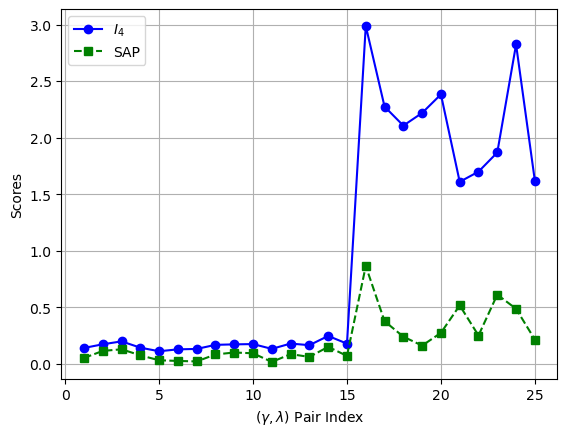

Scenario 2:


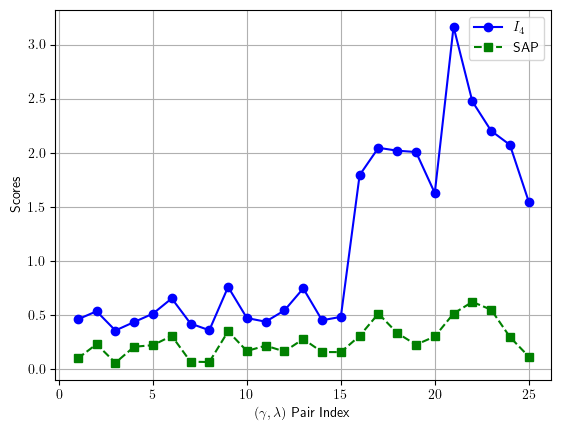

Scenario 3:


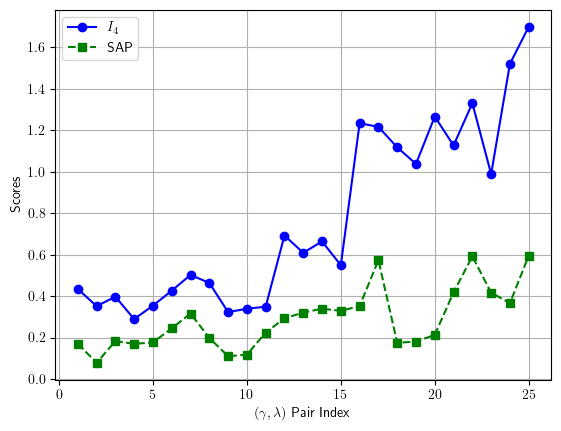

In [16]:
# Divide into three arrays, each with 25 values for each scenario
SAP_1, SAP_2, SAP_3 = np.array_split(all_SAP_score_arr, 3)
I4_1, I4_2, I4_3 = np.array_split(all_I4_score_arr, 3)

# Plot Comparison of I4 and SAP Scores for each scenario
print(colored('Scenario 1:', attrs=['bold', 'underline']))
plot_comparison(I4_1, SAP_1)

print(colored('Scenario 2:', attrs=['bold', 'underline']))
plot_comparison(I4_2, SAP_2)

print(colored('Scenario 3:', attrs=['bold', 'underline']))
plot_comparison(I4_3, SAP_3)

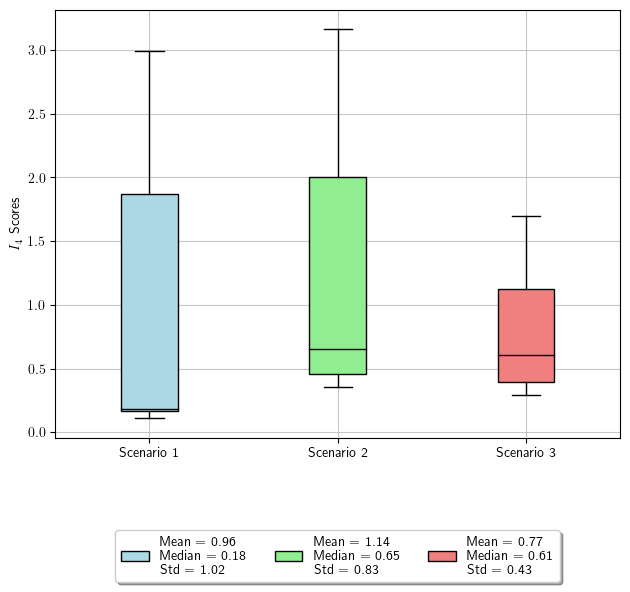

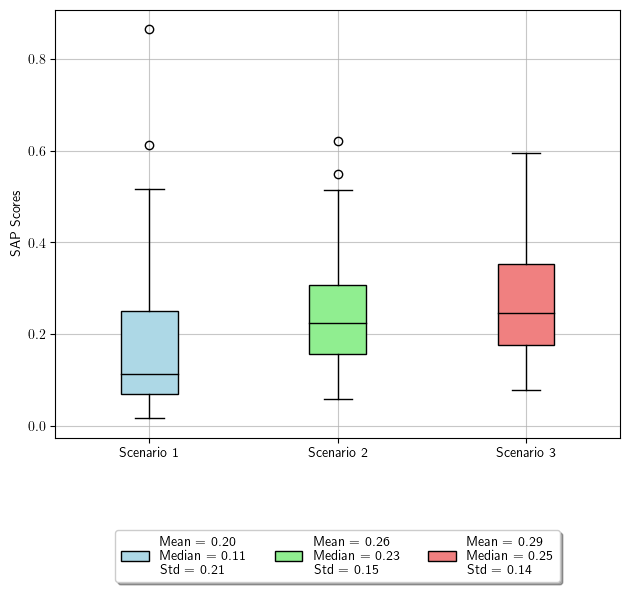

In [17]:
# Plots of Distribution of I4 and SAP Scores Across Scenarios
plot_score_across_scenarios(I4_1, I4_2, I4_3, 0)
plot_score_across_scenarios(SAP_1, SAP_2, SAP_3, 1)

Scenario 1:


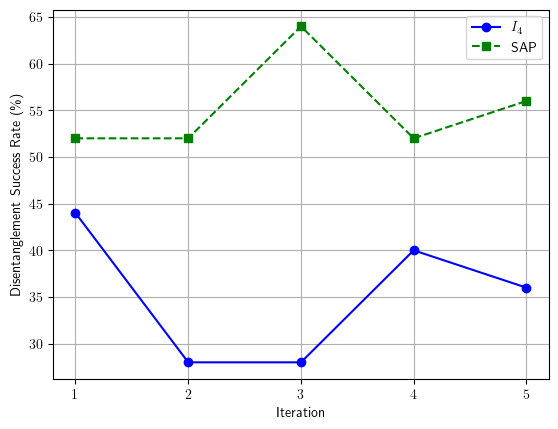

Scenario 2:


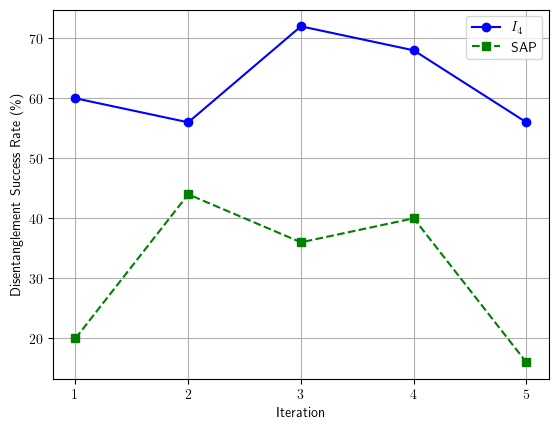

Scenario 3:


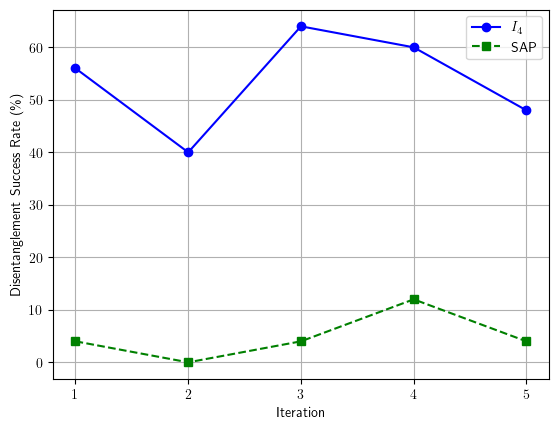

In [18]:
# Plot Comparison of Disentaglement Success Rate using I4 and SAP Metrics for each scenario
def plot_success_rate(y1, y2):
    x = np.arange(1, 6)
    
    plt.plot(x, y1, marker='o', linestyle='-', color='b', label='$I_4$')
    plt.plot(x, y2, marker='s', linestyle='--', color='g', label='SAP')
    
    plt.xlabel('Iteration')
    plt.ylabel('Disentanglement Success Rate (\%)')
    
    plt.xticks(x)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
# Scenario 1
print(colored('Scenario 1:', attrs=['bold', 'underline']))
plot_success_rate([44, 28, 28, 40, 36], [52, 52, 64, 52, 56])

# Scenario 2
print(colored('Scenario 2:', attrs=['bold', 'underline']))
plot_success_rate([60, 56, 72, 68, 56], [20, 44, 36, 40, 16])

# Scenario 3
print(colored('Scenario 3:', attrs=['bold', 'underline']))
plot_success_rate([56, 40, 64, 60, 48], [4, 0, 4, 12, 4])